## Notebook for the transfer annotation using LogReg 

- This notebook was originally developed by `kp9`, and I modified for my research.
- v200527

### Load required modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scanpy as sc

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Set up working environment 

In [78]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 280, color_map = 'inferno_r')

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import multiprocessing
print(multiprocessing.cpu_count())

24


### Load the dataset to be annotated

- Read in the heart immune and replace it in the _tissues_ object

In [5]:
heart = sc.read_h5ad('/home/jovyan/experiments/2-subpopulations/4-immune/heart_immmune_scGen_raw_ctl200520_annotated.h5ad')
heart.shape

(40868, 33538)

In [6]:
tissues = sc.read("/home/jovyan/data/KHM/HCA_Heart_SKM_Kidney_RAW_inner_ctl200420.h5ad")
tissues.shape

(56580, 17833)

In [7]:
Kidney = tissues[tissues.obs['tissue'].isin(['Kidney'])]
Kidney.shape

(7803, 17833)

In [8]:
SKM = tissues[tissues.obs['tissue'].isin(['SKM'])]
SKM.shape

(6979, 17833)

In [9]:
tissues = heart.concatenate(Kidney, SKM, batch_key = 'tissue', batch_categories = ['Heart', 'Kidney', 'SKM'], join = 'inner')
tissues.shape

(55650, 17833)

In [10]:
tissues.X.data[:5]

array([1., 1., 1., 1., 1.], dtype=float32)

In [11]:
tissues.obs['tissue'].cat.categories

Index(['Heart', 'Kidney', 'SKM'], dtype='object')

In [12]:
tissues.obs['cell_states'] = tissues.obs['cell_states'].astype('category')
tissues.obs['cell_states'].cat.categories

Index(['B cell', 'B-cells13_MZB1+', 'B-cells14_MS4A1+', 'B_cells', 'CD16+Mo',
       'CD16+NK_1', 'CD16+NK_2', 'CD4 T cell', 'CD4+T_ctl', 'CD4+T_naive',
       'CD8 T cell', 'CD8+T_cytox', 'CD8+T_tem', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'MNP-a/classical monocyte derived',
       'MNP-b/non-classical monocyte derived', 'MNP-c/dendritic cell',
       'MNP-d/Tissue macrophage', 'Mast', 'Mast cell', 'Mast-cells17_CPA3+',
       'Mo_classic', 'Mo_pi', 'Myeloid16_CD1E+', 'Myeloid8_S100A12+', 'MØ_AgP',
       'MØ_trmod', 'NK cell', 'NK-cells12_CD274+', 'NKT cell', 'Neutrophil',
       'NØ', 'Plasmacytoid dendritic cell', 'T-cells7', 'doublets', 'dpT',
       'ØdDC_1', 'ØdDC_2'],
      dtype='object')

In [13]:
kidney = tissues[tissues.obs['tissue'].isin(['Kidney'])]
kidney.obs['cell_states'].cat.categories

Index(['B cell', 'CD4 T cell', 'CD8 T cell',
       'MNP-a/classical monocyte derived',
       'MNP-b/non-classical monocyte derived', 'MNP-c/dendritic cell',
       'MNP-d/Tissue macrophage', 'Mast cell', 'NK cell', 'NKT cell',
       'Neutrophil', 'Plasmacytoid dendritic cell'],
      dtype='object')

In [14]:
SKM = tissues[tissues.obs['tissue'].isin(['SKM'])]
SKM.obs['cell_states'].cat.categories

Index(['B-cells13_MZB1+', 'B-cells14_MS4A1+', 'Mast-cells17_CPA3+',
       'Myeloid16_CD1E+', 'Myeloid8_S100A12+', 'NK-cells12_CD274+',
       'T-cells7'],
      dtype='object')

In [15]:
heart = tissues[tissues.obs['tissue'].isin(['Heart'])]
heart.obs['cell_states'].cat.categories

Index(['B_cells', 'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'CD4+T_ctl',
       'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod', 'NØ', 'doublets', 'dpT', 'ØdDC_1', 'ØdDC_2'],
      dtype='object')

In [16]:
list(kidney.obs.cell_states.unique())

['NK cell',
 'CD4 T cell',
 'B cell',
 'CD8 T cell',
 'MNP-a/classical monocyte derived',
 'Neutrophil',
 'MNP-c/dendritic cell',
 'NKT cell',
 'MNP-d/Tissue macrophage',
 'MNP-b/non-classical monocyte derived',
 'Plasmacytoid dendritic cell',
 'Mast cell']

In [17]:
list(heart.obs.cell_states.unique())

['CD4+T_ctl',
 'doublets',
 'ØdDC_1',
 'Mast',
 'LYVE1+MØ_tr2',
 'LYVE1+MØ_tr3',
 'CD8+T_tem',
 'CD16+NK_1',
 'CD16+NK_2',
 'CD8+T_cytox',
 'dpT',
 'Mo_pi',
 'CD16+Mo',
 'CD4+T_naive',
 'B_cells',
 'LYVE1+MØ_tr1',
 'MØ_AgP',
 'Mo_classic',
 'ØdDC_2',
 'MØ_trmod',
 'IL17RA+Mo',
 'NØ']

### Process data

In [18]:
target_clusters = ['CD4+T_ctl','ØdDC_1','Mast','LYVE1+MØ_tr2','LYVE1+MØ_tr3','CD8+T_tem','CD16+NK_1','CD16+NK_2','CD8+T_cytox','dpT','Mo_pi','CD16+Mo','CD4+T_naive','B_cells','LYVE1+MØ_tr1','MØ_AgP','Mo_classic','ØdDC_2','MØ_trmod','IL17RA+Mo','NØ']

sc.pp.normalize_per_cell(heart, counts_per_cell_after = 1e4)
sc.pp.log1p(heart)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [19]:
heart.obs.head()
meta = heart.obs

### Train the model

In [20]:
meta_target = meta.loc[meta['cell_states'].isin(target_clusters)]
adata_target = heart[meta_target.index]

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(adata_target.X.todense(),  meta_target['cell_states'].values, test_size = 0.25, random_state = 0)

In [22]:
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C = 0.1)
logisticRegr.fit(x_train, [str(i) for i in y_train])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [23]:
predictions = logisticRegr.predict(x_test)

In [24]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.6862452792685351


In [25]:
cm = metrics.confusion_matrix(y_test, predictions)
cm_pd = pd.DataFrame(cm)
cm_pd

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,286,2,1,1,4,1,1,0,0,1,...,0,0,0,4,0,0,0,1,2,0
1,1,699,0,1,0,0,1,0,1,18,...,5,0,54,32,9,0,0,0,20,14
2,0,0,826,77,7,0,14,10,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,123,199,15,2,9,21,0,0,...,0,0,0,3,0,0,0,2,4,0
4,1,1,6,17,448,46,55,146,0,0,...,1,0,1,14,0,0,0,2,5,0
5,2,0,0,0,33,178,14,18,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,11,0,71,13,534,106,0,2,...,1,0,0,1,0,0,0,7,2,0
7,0,0,7,16,158,9,130,424,0,2,...,3,0,0,1,0,0,0,11,7,0
8,0,7,0,0,0,0,0,0,3,0,...,0,0,0,0,1,0,0,1,0,0
9,0,14,1,0,0,0,3,1,0,472,...,90,1,0,2,24,45,0,3,36,19


In [26]:
pred_df = pd.DataFrame(predictions)
pred_df['prediction_labels'] = predictions
pred_df['prediction_labels'] = pred_df['prediction_labels'].astype('category')
pred_df['prediction_labels'].cat.categories

Index(['B_cells', 'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'CD4+T_ctl',
       'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod', 'NØ', 'dpT', 'ØdDC_1', 'ØdDC_2'],
      dtype='object')

In [27]:
cm_pd = pd.DataFrame(cm, index = pred_df['prediction_labels'].cat.categories, columns = pred_df['prediction_labels'].cat.categories)
cm_pd

,B_cells,CD16+Mo,CD16+NK_1,CD16+NK_2,CD4+T_ctl,CD4+T_naive,CD8+T_cytox,CD8+T_tem,IL17RA+Mo,LYVE1+MØ_tr1,...,LYVE1+MØ_tr3,Mast,Mo_classic,Mo_pi,MØ_AgP,MØ_trmod,NØ,dpT,ØdDC_1,ØdDC_2
B_cells,286,2,1,1,4,1,1,0,0,1,...,0,0,0,4,0,0,0,1,2,0
CD16+Mo,1,699,0,1,0,0,1,0,1,18,...,5,0,54,32,9,0,0,0,20,14
CD16+NK_1,0,0,826,77,7,0,14,10,0,0,...,0,0,0,0,0,0,0,0,1,0
CD16+NK_2,1,0,123,199,15,2,9,21,0,0,...,0,0,0,3,0,0,0,2,4,0
CD4+T_ctl,1,1,6,17,448,46,55,146,0,0,...,1,0,1,14,0,0,0,2,5,0
CD4+T_naive,2,0,0,0,33,178,14,18,0,0,...,0,0,0,0,0,0,0,0,0,0
CD8+T_cytox,0,1,11,0,71,13,534,106,0,2,...,1,0,0,1,0,0,0,7,2,0
CD8+T_tem,0,0,7,16,158,9,130,424,0,2,...,3,0,0,1,0,0,0,11,7,0
IL17RA+Mo,0,7,0,0,0,0,0,0,3,0,...,0,0,0,0,1,0,0,1,0,0
LYVE1+MØ_tr1,0,14,1,0,0,0,3,1,0,472,...,90,1,0,2,24,45,0,3,36,19


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text yticklabel objects>)

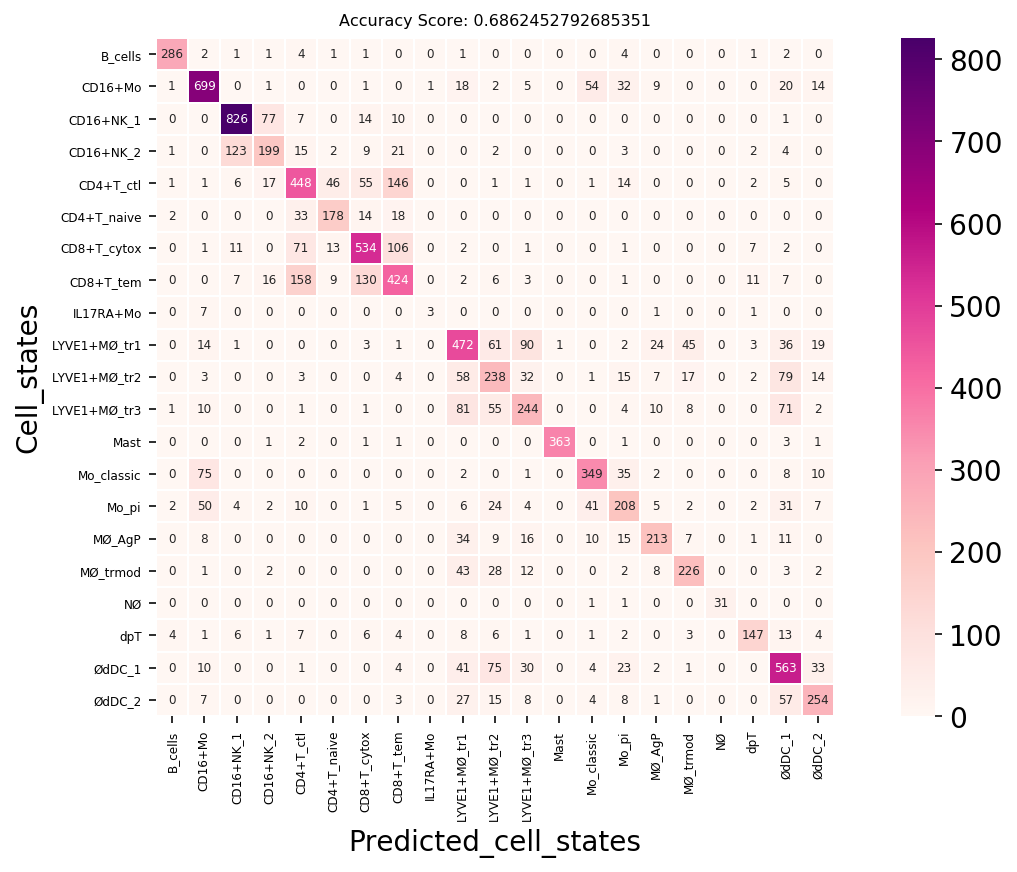

In [28]:
plt.figure(figsize = (12,6))

sns.heatmap(cm_pd, annot = True, fmt = "d", linewidths = 0.5, square = True, cmap = 'RdPu', annot_kws = {"size": 6});
plt.ylabel('Cell_states');
plt.xlabel('Predicted_cell_states');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 8);
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)

### Run predictions for SKM

In [29]:
sc.pp.normalize_per_cell(SKM, counts_per_cell_after = 1e4)
sc.pp.log1p(SKM)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [30]:
SKM.obs['predictions'] = logisticRegr.predict(SKM.X.todense())
probabilities = logisticRegr.predict_proba(SKM.X.todense())
probs_SKM = []
for i,clus in enumerate(SKM.obs['predictions']):
    probs_SKM.append(probabilities[i,logisticRegr.classes_==clus][0])
SKM.obs['probabilities'] = probs_SKM

In [31]:
SKM.obs['predictions'].head()

AAACGGGGTCTACCTC-1-mus_SNuc7444586-SKM-SKM       CD4+T_ctl
AAAGCAAGTTCTCATT-1-mus_SNuc7444586-SKM-SKM    LYVE1+MØ_tr2
AAAGTAGCACAACGTT-1-mus_SNuc7444586-SKM-SKM    LYVE1+MØ_tr2
AACCGCGCAAACCTAC-1-mus_SNuc7444586-SKM-SKM       CD4+T_ctl
AACCGCGCATCGATTG-1-mus_SNuc7444586-SKM-SKM           Mo_pi
Name: predictions, dtype: object

### Run predictions for Kidney

In [32]:
sc.pp.normalize_per_cell(kidney, counts_per_cell_after = 1e4)
sc.pp.log1p(kidney)

kidney.obs['predictions'] = logisticRegr.predict(kidney.X.todense())
probabilities = logisticRegr.predict_proba(kidney.X.todense())
probs_kidney = []
for i,clus in enumerate(kidney.obs['predictions']):
    probs_kidney.append(probabilities[i,logisticRegr.classes_==clus][0])
kidney.obs['probabilities'] = probs_kidney

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Select cells with higher probability 

In [33]:
SKM_sig = SKM[SKM.obs['probabilities'] > 0.8]
SKM_sig.shape

(4765, 17833)

In [34]:
SKM_sig.obs['predictions'] = SKM_sig.obs['predictions'].astype('category')
SKM_sig.obs['predictions'].cat.categories

Trying to set attribute `.obs` of view, copying.


Index(['B_cells', 'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'CD4+T_ctl',
       'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'NØ', 'dpT', 'ØdDC_1'],
      dtype='object')

In [35]:
kidney_sig = kidney[kidney.obs['probabilities'] > 0.8]
kidney_sig.shape

(5882, 17833)

In [36]:
kidney_sig.obs['predictions'] = kidney_sig.obs['predictions'].astype('category')
kidney_sig.obs['predictions'].cat.categories

Trying to set attribute `.obs` of view, copying.


Index(['B_cells', 'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'CD4+T_ctl',
       'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod', 'NØ', 'dpT', 'ØdDC_1'],
      dtype='object')

### Merge datasets

In [37]:
heart.obs['predictions'] = heart.obs['cell_states']
heart.obs['predictions'].cat.categories

Index(['B_cells', 'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'CD4+T_ctl',
       'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod', 'NØ', 'doublets', 'dpT', 'ØdDC_1', 'ØdDC_2'],
      dtype='object')

In [38]:
HKM = heart.concatenate(kidney_sig, SKM_sig, batch_key = 'tissues', batch_categories = ['Heart', 'Kidney', 'SKM'], join = 'inner')
HKM.shape

(51515, 17833)

In [39]:
HKM.write('/home/jovyan/experiments/9-comparative_analyses/immune_skm_heart_kidney/HCA_Heart_SKM_Kidney_RAW_inner_ctl200530_log.h5ad')

... storing 'CoD' as categorical
... storing 'Experiment' as categorical
... storing 'NRP' as categorical
... storing 'Project' as categorical
... storing 'age' as categorical
... storing 'age_group' as categorical
... storing 'batch' as categorical
... storing 'broad_celltype' as categorical
... storing 'cell_source' as categorical
... storing 'cell_states' as categorical
... storing 'cell_type' as categorical
... storing 'celltype' as categorical
... storing 'compartment' as categorical
... storing 'donor' as categorical
... storing 'gender' as categorical
... storing 'immune_states' as categorical
... storing 'leiden' as categorical
... storing 'leiden_annotated' as categorical
... storing 'predictions' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical
... storing 'source' as categorical
... storing 'tissue' as categorical
... storing 'type' as categorical
... storing 'version' as categorical


### Select predicted cell state to compare

In [40]:
HKM.obs['predictions'].cat.categories

Index(['B_cells', 'CD4+T_ctl', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem',
       'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod', 'NØ', 'doublets', 'dpT', 'ØdDC_1', 'ØdDC_2'],
      dtype='object')

In [41]:
pd.crosstab(HKM.obs['predictions'], HKM.obs['tissues'])

tissues,Heart,Kidney,SKM
predictions,,,
B_cells,1195,993,1304
CD4+T_ctl,3113,555,257
CD4+T_naive,1047,909,489
CD8+T_cytox,2956,1026,243
CD8+T_tem,3001,233,142
CD16+Mo,3278,501,382
CD16+NK_1,3628,893,517
CD16+NK_2,1463,249,294
IL17RA+Mo,32,0,0


In [42]:
HKM_LYVE1MØ = HKM[HKM.obs['predictions'].isin(['LYVE1+MØ_tr1','LYVE1+MØ_tr2','LYVE1+MØ_tr3'])]
HKM_LYVE1MØ.shape

(7435, 17833)

In [43]:
pd.crosstab(HKM_LYVE1MØ.obs['predictions'], HKM_LYVE1MØ.obs['tissues'])

tissues,Heart,Kidney,SKM
predictions,,,
LYVE1+MØ_tr1,3018,13,5
LYVE1+MØ_tr2,2088,15,146
LYVE1+MØ_tr3,1957,78,115


In [44]:
sc.tl.rank_genes_groups(HKM_LYVE1MØ, 'tissues', method = 'wilcoxon', n_genes = 200)
result = HKM_LYVE1MØ.uns['rank_genes_groups']
groups = result['names'].dtype.names
pop_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
pop_markers.head(10)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


,Heart_n,Heart_l,Heart_p,Kidney_n,Kidney_l,Kidney_p,SKM_n,SKM_l,SKM_p
0,F13A1,5.197642,1.361543e-111,RPS17,4.427196,1.908580e-45,RPL26,3.714328,6.584043e-93
1,CD163,3.417211,3.623121e-79,HLA-DQB1,4.355402,1.514752e-44,RPL10,3.365900,1.502743e-89
2,RBPJ,3.435347,2.653396e-74,HLA-DQA1,4.498780,1.254150e-40,RPL41,3.541945,2.366264e-86
3,FRMD4B,4.022815,6.107003e-68,HLA-DMA,3.609370,5.651922e-36,RPS27,3.672182,2.227925e-83
4,STAB1,4.256730,1.773038e-67,CXCR4,4.167085,1.949246e-32,EEF1A1,3.505920,2.415070e-83
5,ZEB2,3.195520,2.461138e-60,HLA-DMB,3.708516,1.000496e-31,RPS15A,3.359762,2.868076e-83
6,LYVE1,3.788292,6.581634e-59,HLA-DPB1,3.492914,1.231444e-30,RPS4X,3.383718,4.232922e-83
7,RBM47,4.445797,3.488724e-58,RPS10,3.447051,1.764363e-30,ACTA1,4.812259,1.787448e-80
8,SLC9A9,4.806716,2.861617e-56,HLA-DPA1,3.544834,5.124078e-30,RPL31,3.292246,1.966808e-79
9,MRC1,3.131814,1.518468e-54,RPL5,2.972473,1.928775e-29,RPL35A,3.134644,4.553520e-78


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:07)
Storing dendrogram info using `.uns['dendrogram_tissues']`


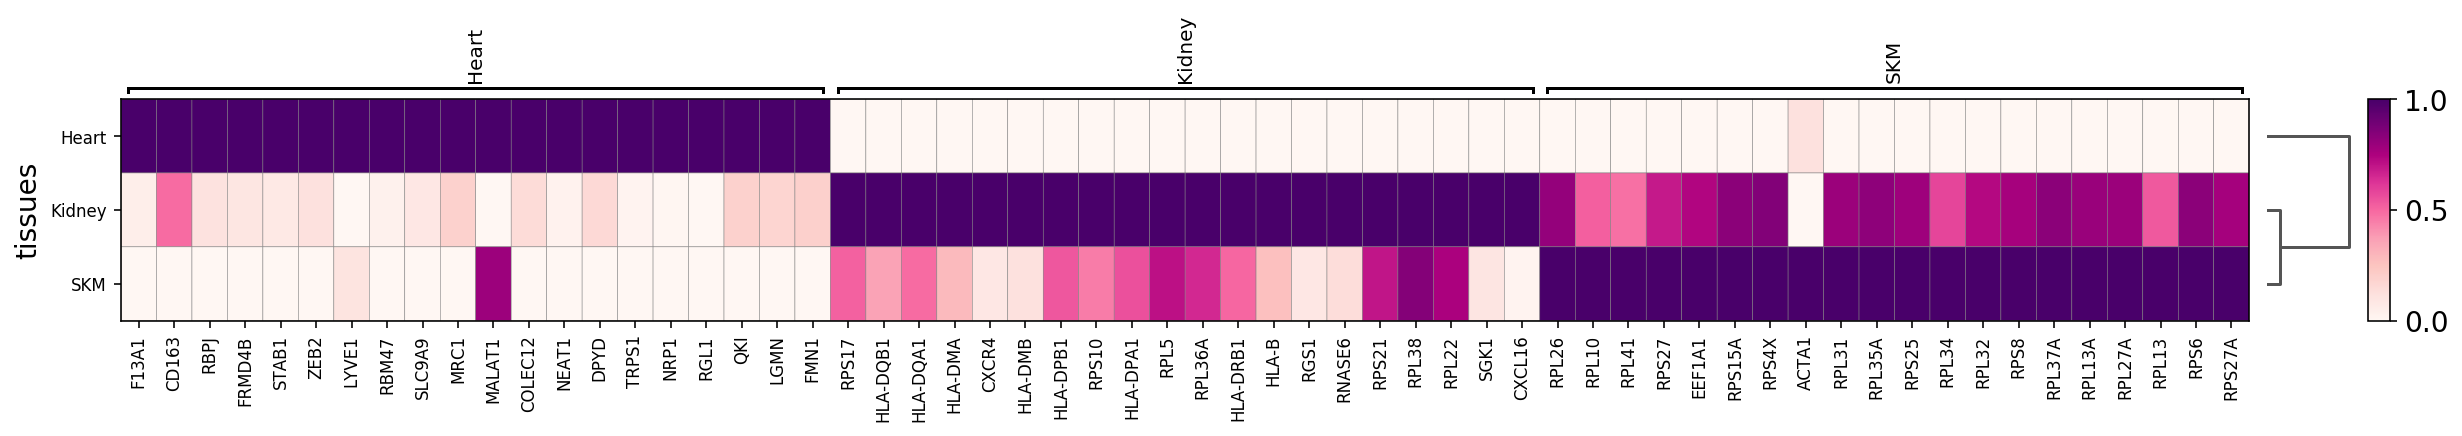

In [45]:
sc.pl.rank_genes_groups_matrixplot(HKM_LYVE1MØ, n_genes = 20, standard_scale = 'var', cmap = 'RdPu')

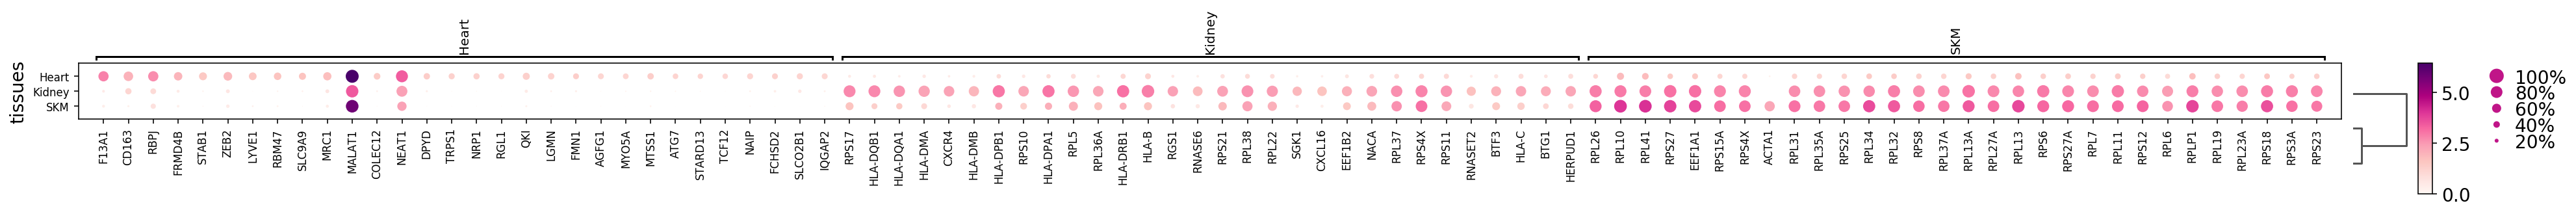

In [46]:
sc.pl.rank_genes_groups_dotplot(HKM_LYVE1MØ, n_genes = 30, color_map = 'RdPu')

In [47]:
HKM_LYVE1MØ_tr2 = HKM[HKM.obs['predictions'].isin(['B_cells', 'CD4+T_ctl', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem',
       'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod'])]
HKM_LYVE1MØ_tr2.shape

(44874, 17833)

In [48]:
sc.tl.rank_genes_groups(HKM_LYVE1MØ_tr2, 'tissues', method = 'wilcoxon', n_genes = 200)
result = HKM_LYVE1MØ_tr2.uns['rank_genes_groups']
groups = result['names'].dtype.names
pop_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
pop_markers.head(5)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:08)


,Heart_n,Heart_l,Heart_p,Kidney_n,Kidney_l,Kidney_p,SKM_n,SKM_l,SKM_p
0,MALAT1,2.024616,0.0,RPS17,2.899537,0.0,ACTA1,5.389499,0.0
1,NEAT1,1.458995,0.0,RPS26,2.727828,0.0,RPL10,2.392659,0.0
2,CD163,3.462662,0.0,NBEAL1,3.916749,0.0,RPL41,2.532819,0.0
3,FKBP5,2.221187,0.0,RPL17,2.589793,0.0,RPL26,2.443548,0.0
4,CTSB,2.182723,0.0,RPS10,1.993149,0.0,EEF1A1,2.443668,0.0


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:40)
Storing dendrogram info using `.uns['dendrogram_tissues']`


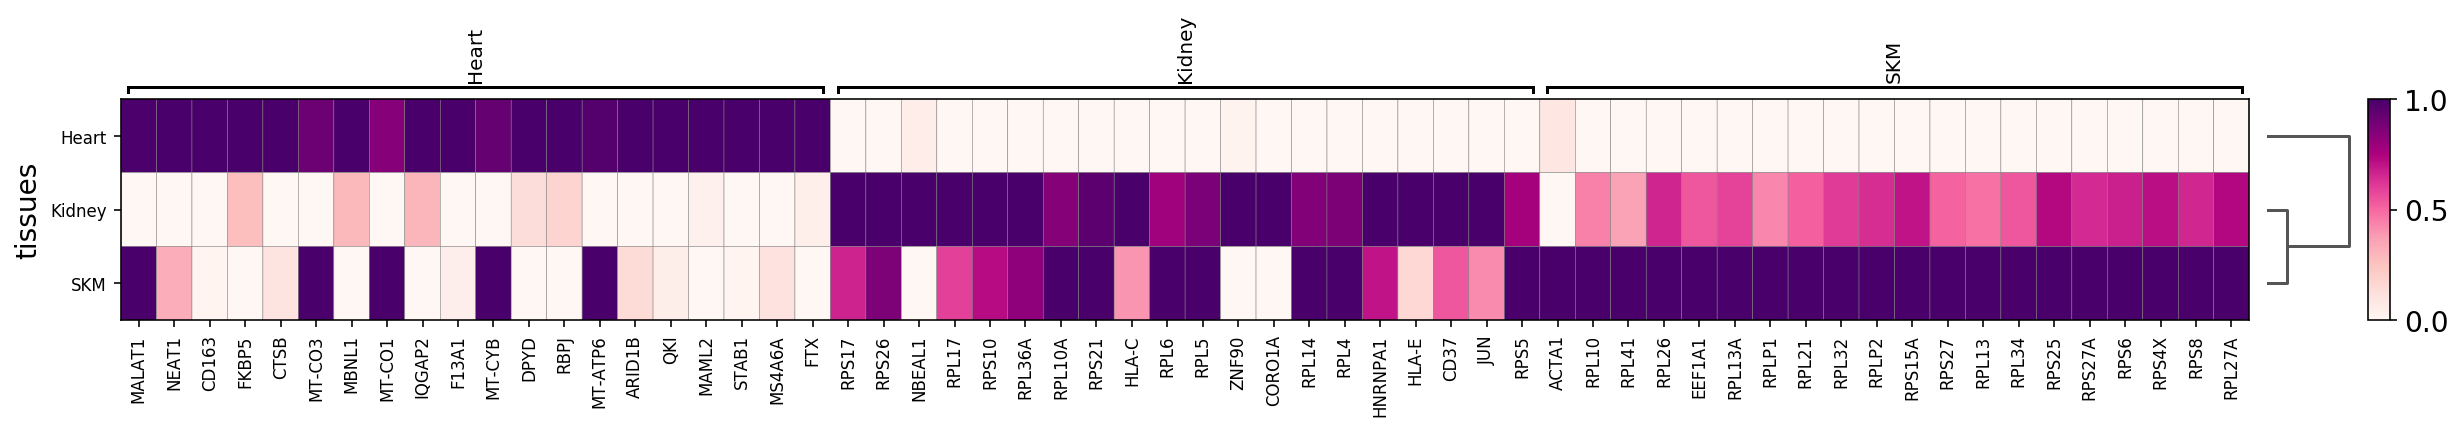

In [49]:
sc.pl.rank_genes_groups_matrixplot(HKM_LYVE1MØ_tr2, n_genes = 20, standard_scale = 'var', cmap = 'RdPu')

In [50]:
HKM_LYVE1MØ_tr3 = HKM[HKM.obs['predictions'].isin(['LYVE1+MØ_tr3'])]
HKM_LYVE1MØ_tr3.shape

(2150, 17833)

In [51]:
sc.tl.rank_genes_groups(HKM_LYVE1MØ_tr3, 'tissues', method = 'wilcoxon', n_genes = 200)
result = HKM_LYVE1MØ_tr3.uns['rank_genes_groups']
groups = result['names'].dtype.names
pop_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
pop_markers.head(5)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


,Heart_n,Heart_l,Heart_p,Kidney_n,Kidney_l,Kidney_p,SKM_n,SKM_l,SKM_p
0,MALAT1,2.117894,9.440200e-42,RPS17,4.494874,3.173097e-35,CST3,4.350584,1.233123e-52
1,F13A1,4.101917,1.168392e-38,HLA-DQB1,3.734307,7.975971e-32,RPL26,3.895122,1.233123e-52
2,RBPJ,2.910777,8.487611e-31,RPS10,3.722229,2.753649e-30,RPL37A,3.668782,2.278483e-51
3,CD163,2.478087,1.183845e-28,HLA-DQA1,3.930136,1.279128e-29,RPLP2,3.633855,1.351603e-50
4,LYVE1,4.071328,2.030057e-28,HLA-DMB,3.529688,2.551446e-29,RPL37,3.711987,1.067874e-49


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:03)
Storing dendrogram info using `.uns['dendrogram_tissues']`


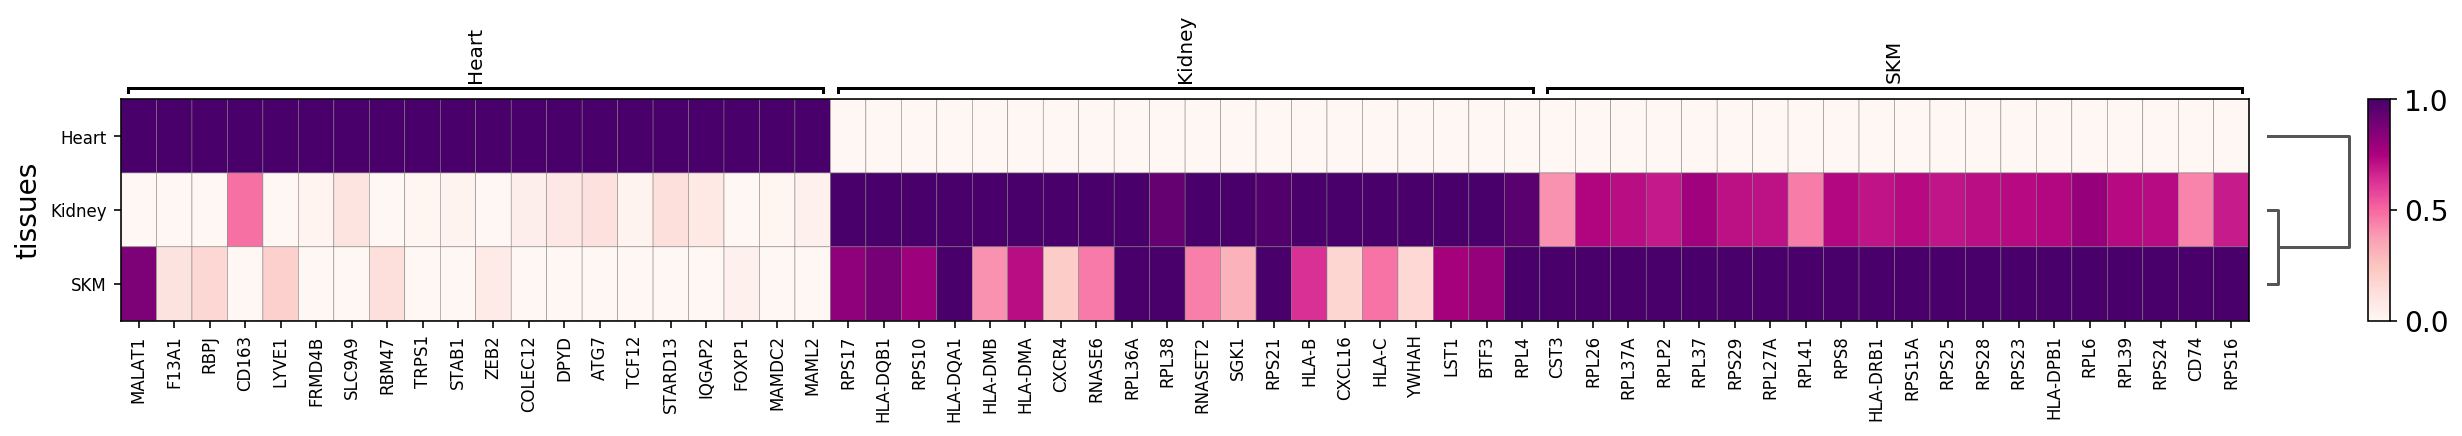

In [52]:
sc.pl.rank_genes_groups_matrixplot(HKM_LYVE1MØ_tr3, n_genes = 20, standard_scale = 'var', cmap = 'RdPu')

In [53]:
HKM_MØ_trmod = HKM[HKM.obs['predictions'].isin(['MØ_trmod'])]
HKM_MØ_trmod.shape

(1316, 17833)

In [54]:
sc.tl.rank_genes_groups(HKM_MØ_trmod, 'tissues', method = 'wilcoxon', n_genes = 200)
result = HKM_MØ_trmod.uns['rank_genes_groups']
groups = result['names'].dtype.names
pop_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
pop_markers.head(5)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


,Heart_n,Heart_l,Heart_p,Kidney_n,Kidney_l,Kidney_p
0,S100A4,34.738960,1.0,HIST1H2BG,8.976114,1.0
1,RPS15,33.691311,1.0,DNAJB11,5.648489,1.0
2,SERF2,33.717312,1.0,TCP1,5.380223,1.0
3,S100A6,34.028477,1.0,STXBP2,5.213244,1.0
4,RPS18,33.931160,1.0,RPS17,4.317832,1.0


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:01)
Storing dendrogram info using `.uns['dendrogram_tissues']`


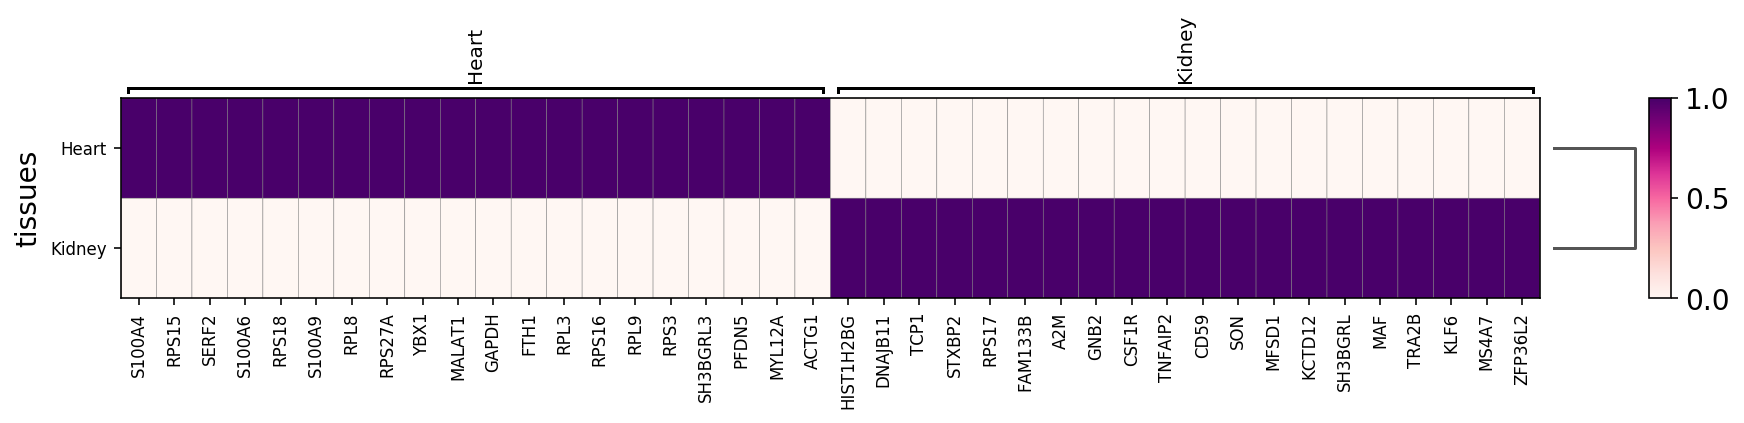

In [55]:
sc.pl.rank_genes_groups_matrixplot(HKM_MØ_trmod, n_genes = 20, standard_scale = 'var', cmap = 'RdPu')

In [56]:
HKM_MØ_AgP = HKM[HKM.obs['predictions'].isin(['MØ_AgP'])]
HKM_MØ_AgP.shape

(1309, 17833)

In [57]:
sc.tl.rank_genes_groups(HKM_MØ_AgP, 'tissues', method = 'wilcoxon', n_genes = 200)
result = HKM_MØ_AgP.uns['rank_genes_groups']
groups = result['names'].dtype.names
pop_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
pop_markers.head(5)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


,Heart_n,Heart_l,Heart_p,Kidney_n,Kidney_l,Kidney_p,SKM_n,SKM_l,SKM_p
0,MT-CO1,2.875679,0.000005,RPS17,3.451999,8.216773e-07,IL1B,6.536763,0.024028
1,MT-CO2,2.528081,0.000005,RPL14,1.493056,2.213739e-03,RPS29,2.146227,0.024028
2,MT-ATP6,3.247216,0.000005,NBEAL1,4.402884,3.389770e-03,CXCL8,5.489710,0.028772
3,MT-CO3,3.121174,0.000006,HLA-DQB1,2.586401,6.393961e-03,RPL15,1.714949,0.049278
4,MT-CYB,2.815400,0.000008,HLA-DQA1,2.999511,7.129452e-03,RPL35,1.608911,0.049278


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:01)
Storing dendrogram info using `.uns['dendrogram_tissues']`


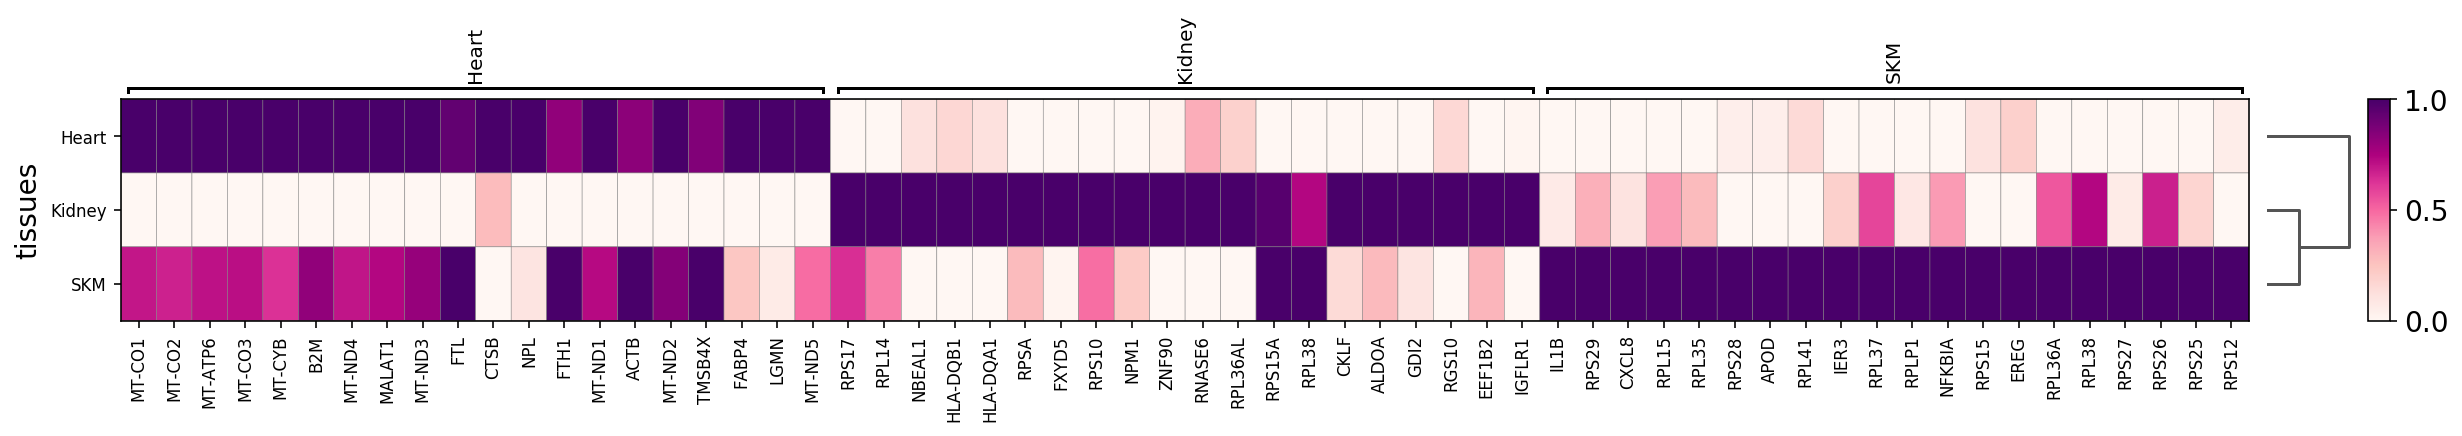

In [58]:
sc.pl.rank_genes_groups_matrixplot(HKM_MØ_AgP, n_genes = 20, standard_scale = 'var', cmap = 'RdPu')

### Myeloid

In [59]:
HKM.obs['predictions'].cat.categories

Index(['B_cells', 'CD4+T_ctl', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_tem',
       'CD16+Mo', 'CD16+NK_1', 'CD16+NK_2', 'IL17RA+Mo', 'LYVE1+MØ_tr1',
       'LYVE1+MØ_tr2', 'LYVE1+MØ_tr3', 'Mast', 'Mo_classic', 'Mo_pi', 'MØ_AgP',
       'MØ_trmod', 'NØ', 'doublets', 'dpT', 'ØdDC_1', 'ØdDC_2'],
      dtype='object')

In [60]:
HKM_myeloid = HKM[HKM.obs['predictions'].isin(['CD16+Mo','IL17RA+Mo','LYVE1+MØ_tr1','LYVE1+MØ_tr2','LYVE1+MØ_tr3','Mast','Mo_classic','Mo_pi','MØ_AgP','MØ_trmod','NØ','ØdDC_1','ØdDC_2'])]
HKM_myeloid.shape

(25419, 17833)

In [61]:
sc.tl.rank_genes_groups(HKM_myeloid, 'tissues', method = 'wilcoxon', n_genes = 200)
result = HKM_myeloid.uns['rank_genes_groups']
groups = result['names'].dtype.names
pop_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
pop_markers.head(5)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)


,Heart_n,Heart_l,Heart_p,Kidney_n,Kidney_l,Kidney_p,SKM_n,SKM_l,SKM_p
0,MALAT1,1.693547,3.733280e-290,RPS17,3.639319,1.196953e-300,RPL26,3.507957,0.0
1,F13A1,4.528383,4.309035e-288,HLA-C,2.538977,1.609013e-229,RPL34,3.509088,0.0
2,CD163,2.720541,8.790972e-268,CSTA,3.297809,1.900289e-207,RPS27,3.528206,0.0
3,FRMD4B,4.139424,1.837190e-241,RPS26,2.801747,1.936749e-203,RPL41,3.323516,0.0
4,RBPJ,2.832747,1.438256e-227,IFI30,3.645546,1.030686e-198,RPL21,3.388999,0.0


In [62]:
pop_markers.to_csv('/home/jovyan/experiments/9-comparative_analyses/immune_skm_heart_kidney/myeloid_HKM_wilcox.csv', sep = ',', index = False)

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:20)
Storing dendrogram info using `.uns['dendrogram_tissues']`


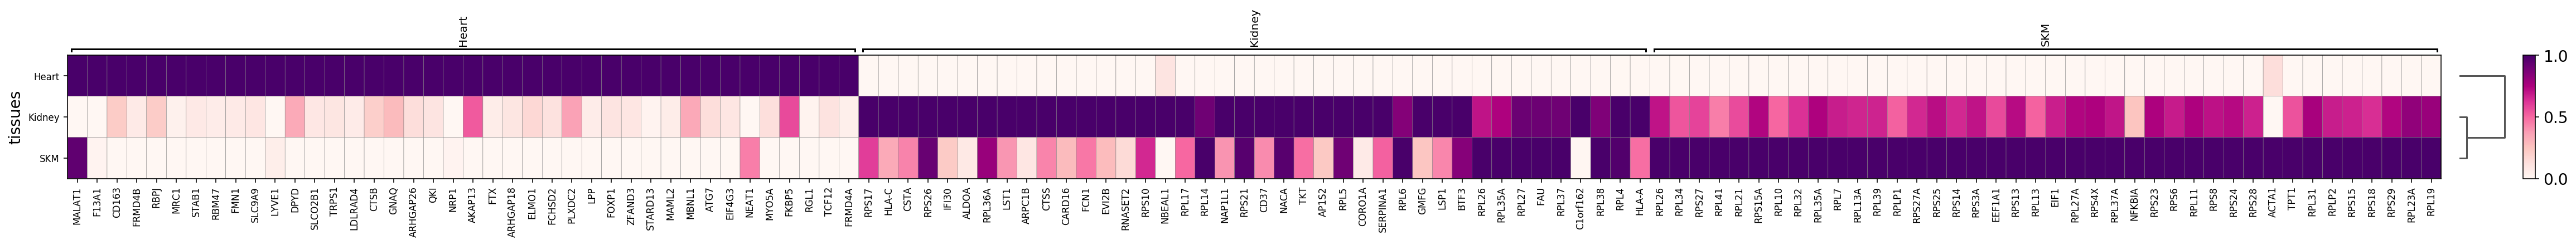

In [63]:
sc.pl.rank_genes_groups_matrixplot(HKM_myeloid, n_genes = 40, standard_scale = 'var', cmap = 'RdPu')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_tissues']`


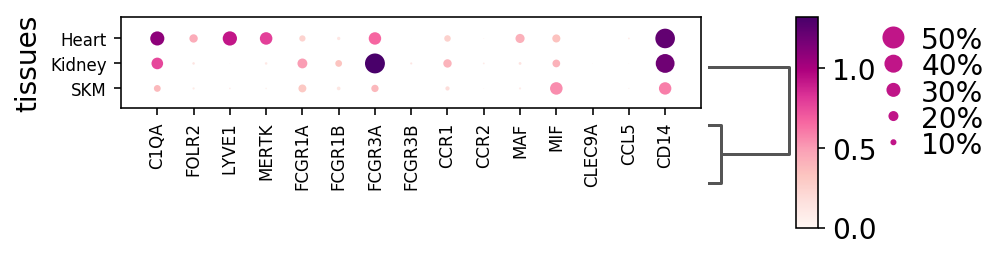

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[5.25, 0.8, 0.2, 0.5, 0.25])

In [64]:
capEC = ["C1QA","FOLR2","LYVE1","MERTK","FCGR1A","FCGR1B",'FCGR3A','FCGR3B',"CCR1","CCR2","MAF","MIF","CLEC9A",'CCL5','CD14']
sc.tl.dendrogram(HKM_myeloid, groupby = 'tissues')
sc.pl.dotplot(HKM_myeloid, capEC, groupby = 'tissues', color_map = 'RdPu', dendrogram = True)

In [65]:
KM_myeloid = HKM_myeloid[HKM_myeloid.obs['tissues'].isin(['Kidney', 'SKM'])]
KM_myeloid.shape

(2391, 17833)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_predictions']`


Trying to set attribute `.uns` of view, copying.


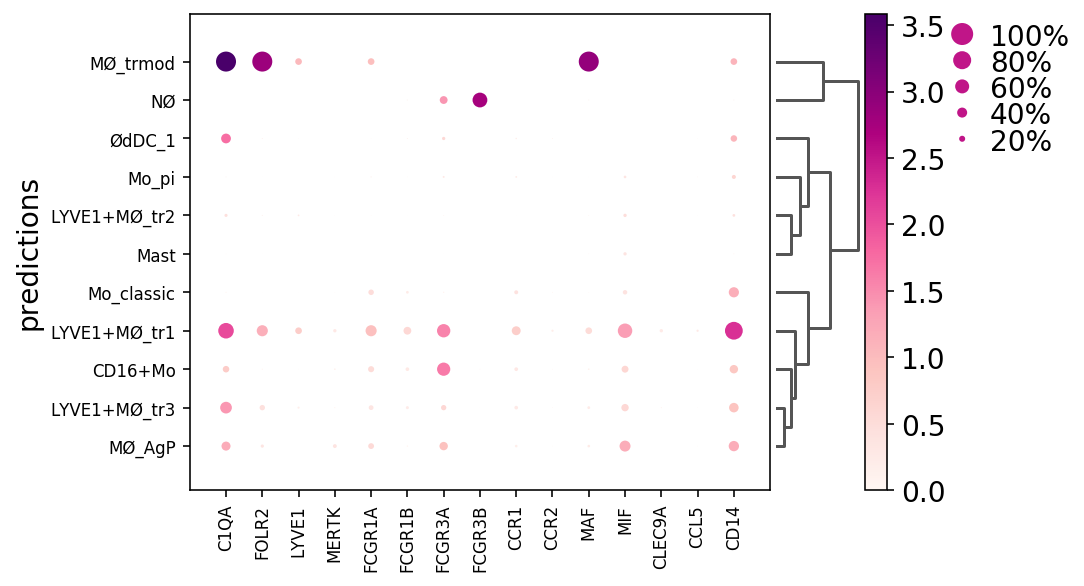

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[5.25, 0.8, 0.2, 0.5, 0.25])

In [66]:
capEC = ["C1QA","FOLR2","LYVE1","MERTK","FCGR1A","FCGR1B",'FCGR3A','FCGR3B',"CCR1","CCR2","MAF","MIF","CLEC9A",'CCL5','CD14']
sc.tl.dendrogram(KM_myeloid, groupby = 'predictions')
sc.pl.dotplot(KM_myeloid, capEC, groupby = 'predictions', color_map = 'RdPu', dendrogram = True)

### Export object with predictions

In [67]:
HKM.obs.index

Index(['AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAATGGAGTTGTCTAG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AACAACCGTAATTGGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAGCATCGTTCGCGTG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAGCCATCAGCACAGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       'AAGTACCTCGTTCTAT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart-Heart',
       ...
       'TTGTAGGCAAGAGGCT-1-5386STDY7645354-SKM-SKM-SKM',
       'TTGTAGGCATTACGAC-1-5386STDY7645354-SKM-SKM-SKM',
       'TTGTAGGTCGTCACGG-1-5386STDY7645354-SKM-SKM-SKM'

In [68]:
tissues = tissues[~tissues.obs['cell_states'].isin(['doublets'])]
tissues.obs.index

Index(['AAAGTGAAGTCGGCCT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAATGGAAGGTCCCTG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AACAACCGTAATTGGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGACTCTCAGGACGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGCATCGTTCGCGTG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGCCATCAGCACAGA-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGCGAGTCAAGGTGG-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGTACCGTCTTACTT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGTACCTCGTTCTAT-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       'AAGTTCGCAGTGTATC-1-H0015_apex-Harvard-Nuclei-Harvard-Nuclei-Heart',
       ...
       'TTTACTGAGACGACGT-1-5386STDY7645354-SKM-SKM',
       'TTTACTGCAGGGTATG-1-5386STDY7645354-SKM-SKM',
       'TTTACTGTCCACTCCA-1-5386STDY7645354-SKM-SKM',
       'TTTATGCAGCGATTCT-1-5386STDY7645354-SKM-SKM',
       'TTTCCTCCA

In [69]:
HKM.obs['cellIDs'] = HKM.obs.index

In [70]:
HKM.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in HKM.obs.index])
HKM.obs.index

Index(['AAAGTGAAGTCGGCCT-1-H0015_apex', 'AAATGGAAGGTCCCTG-1-H0015_apex',
       'AAATGGAGTTGTCTAG-1-H0015_apex', 'AACAACCGTAATTGGA-1-H0015_apex',
       'AAGACTCTCAGGACGA-1-H0015_apex', 'AAGCATCGTTCGCGTG-1-H0015_apex',
       'AAGCCATCAGCACAGA-1-H0015_apex', 'AAGCGAGTCAAGGTGG-1-H0015_apex',
       'AAGTACCGTCTTACTT-1-H0015_apex', 'AAGTACCTCGTTCTAT-1-H0015_apex',
       ...
       'TTGTAGGCAAGAGGCT-1-5386STDY7645354',
       'TTGTAGGCATTACGAC-1-5386STDY7645354',
       'TTGTAGGTCGTCACGG-1-5386STDY7645354',
       'TTTACTGAGACGACGT-1-5386STDY7645354',
       'TTTCCTCCAACTGGCC-1-5386STDY7645354',
       'TTTCCTCTCGTCTGCT-1-5386STDY7645354',
       'TTTGCGCAGATAGCAT-1-5386STDY7645354',
       'TTTGCGCCATGCCTTC-1-5386STDY7645354',
       'TTTGCGCGTTCCAACA-1-5386STDY7645354',
       'TTTGGTTAGCGTAGTG-1-5386STDY7645354'],
      dtype='object', length=51515)

In [71]:
tissues.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in tissues.obs.index])
tissues.obs.index

Index(['AAAGTGAAGTCGGCCT-1-H0015_apex', 'AAATGGAAGGTCCCTG-1-H0015_apex',
       'AACAACCGTAATTGGA-1-H0015_apex', 'AAGACTCTCAGGACGA-1-H0015_apex',
       'AAGCATCGTTCGCGTG-1-H0015_apex', 'AAGCCATCAGCACAGA-1-H0015_apex',
       'AAGCGAGTCAAGGTGG-1-H0015_apex', 'AAGTACCGTCTTACTT-1-H0015_apex',
       'AAGTACCTCGTTCTAT-1-H0015_apex', 'AAGTTCGCAGTGTATC-1-H0015_apex',
       ...
       'TTTACTGAGACGACGT-1-5386STDY7645354',
       'TTTACTGCAGGGTATG-1-5386STDY7645354',
       'TTTACTGTCCACTCCA-1-5386STDY7645354',
       'TTTATGCAGCGATTCT-1-5386STDY7645354',
       'TTTCCTCCAACTGGCC-1-5386STDY7645354',
       'TTTCCTCTCGTCTGCT-1-5386STDY7645354',
       'TTTGCGCAGATAGCAT-1-5386STDY7645354',
       'TTTGCGCCATGCCTTC-1-5386STDY7645354',
       'TTTGCGCGTTCCAACA-1-5386STDY7645354',
       'TTTGGTTAGCGTAGTG-1-5386STDY7645354'],
      dtype='object', length=55027)

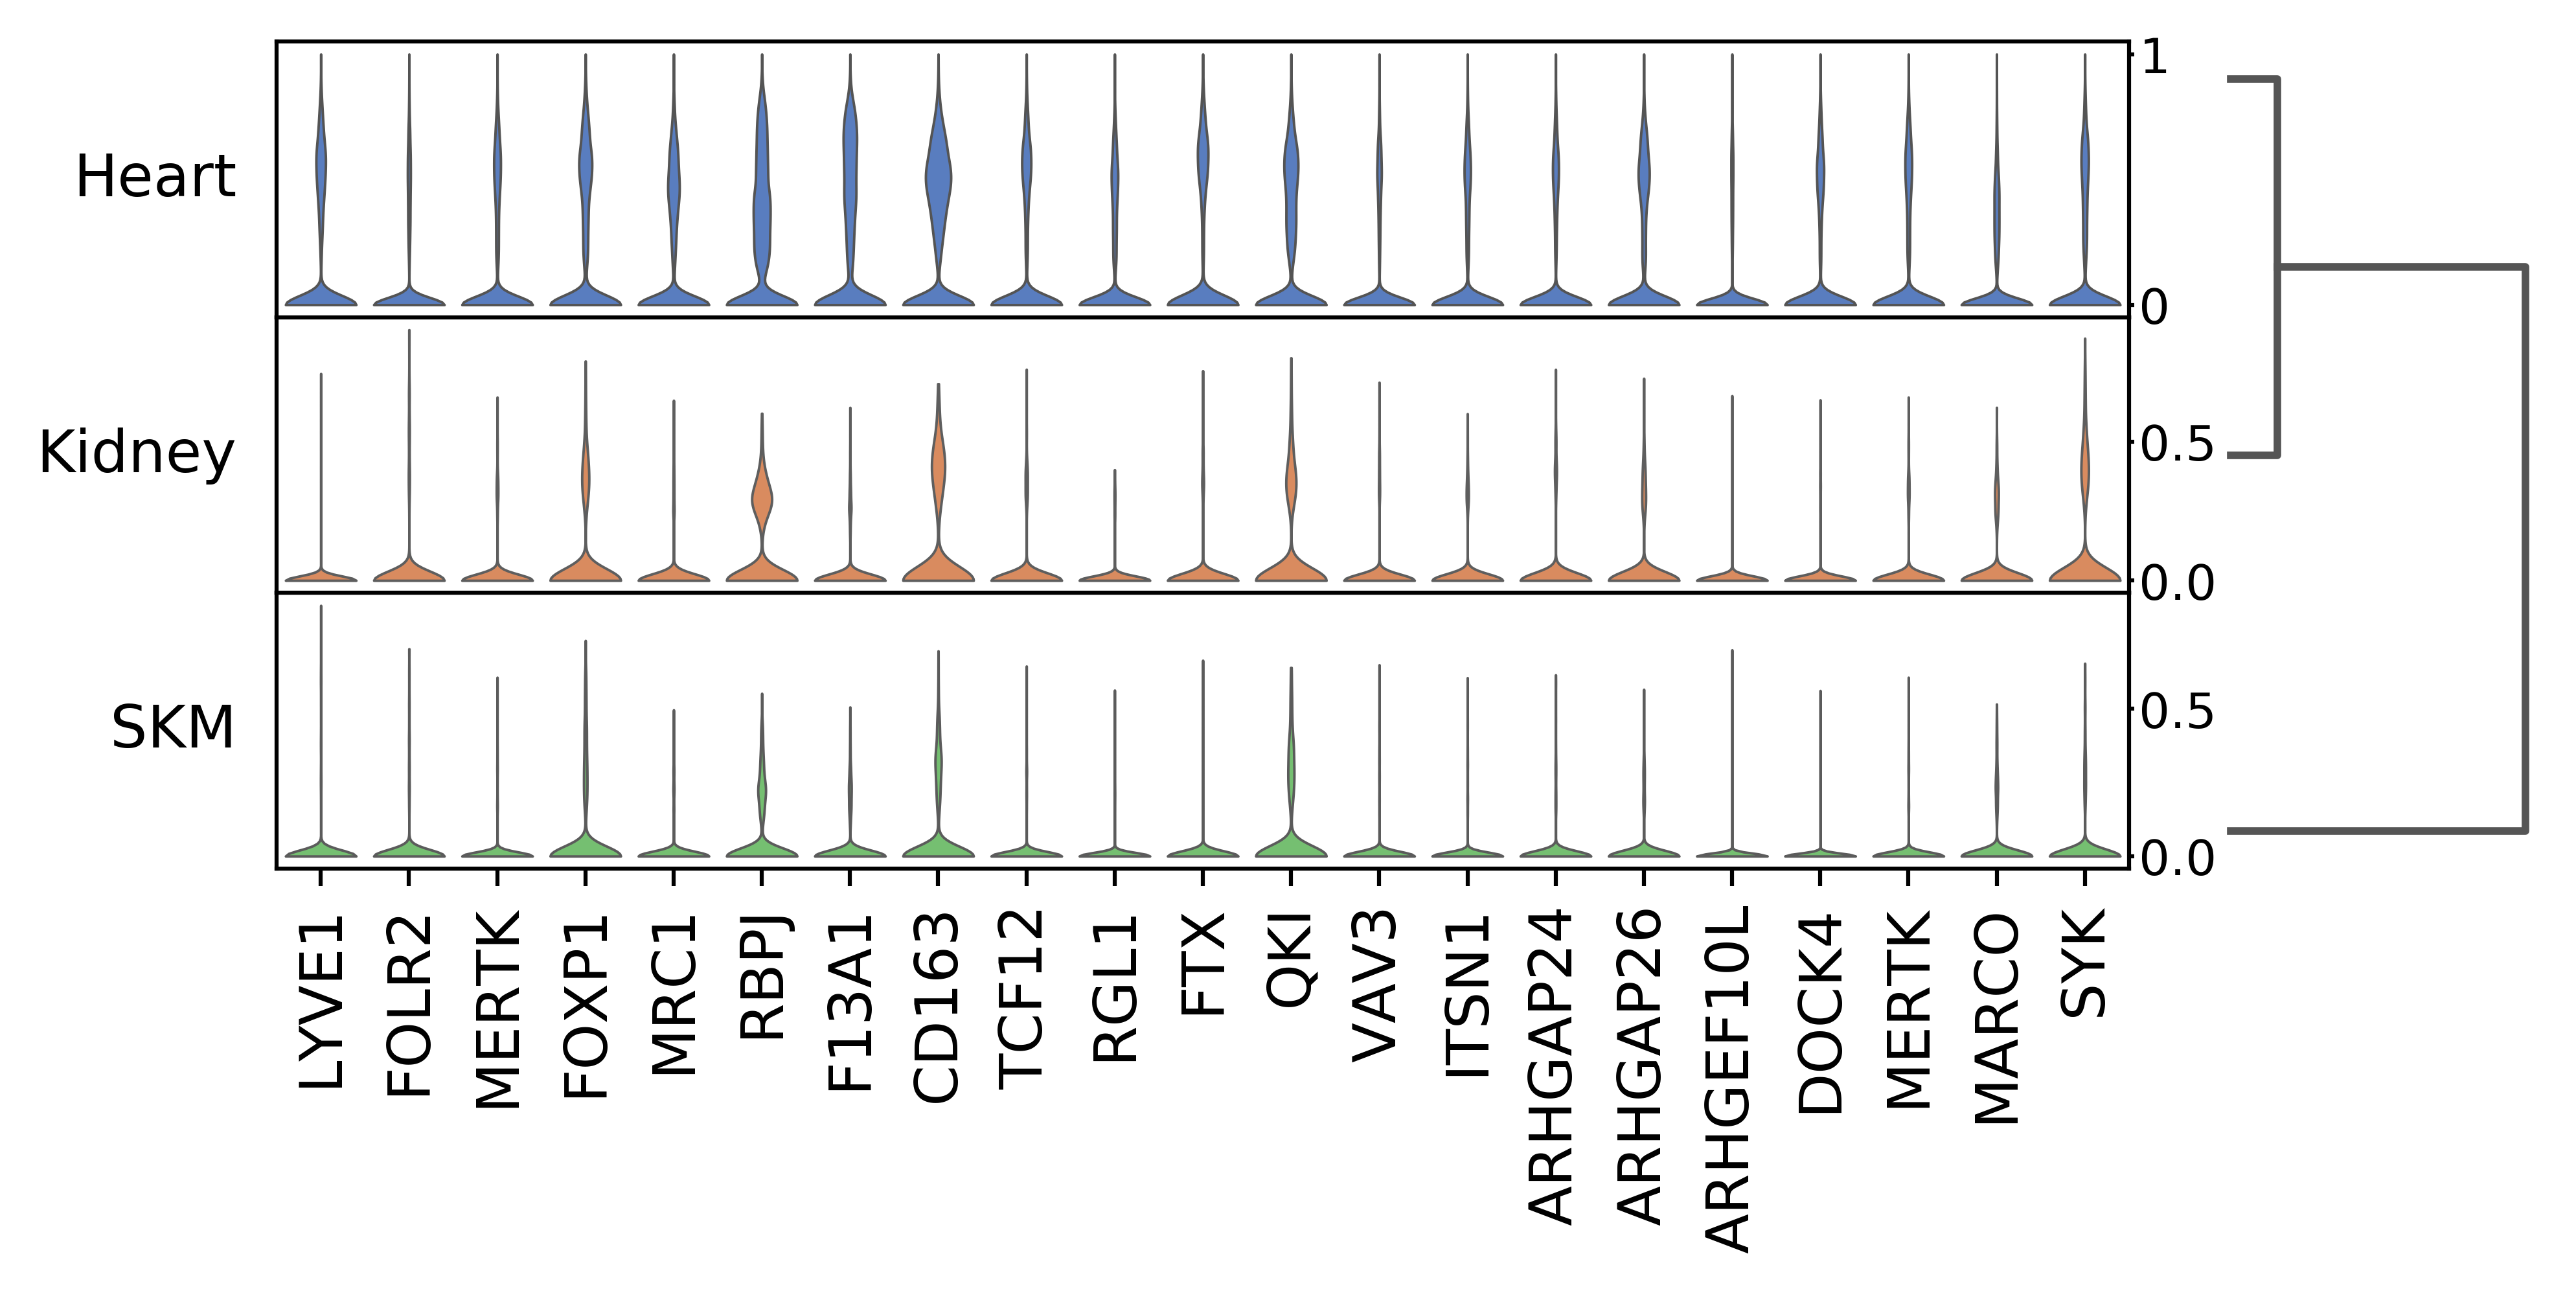

In [83]:
cardiac_myeloid = ["LYVE1","FOLR2","MERTK","FOXP1",'MRC1','RBPJ',"F13A1","CD163","TCF12","RGL1","FTX","QKI","VAV3","ITSN1","ARHGAP24","ARHGAP26","ARHGEF10L","DOCK4","MERTK","MARCO","SYK"]
sc.pl.stacked_violin(HKM_myeloid, cardiac_myeloid, groupby = 'tissues', dendrogram = True, standard_scale = 'var', figsize = (8,3))

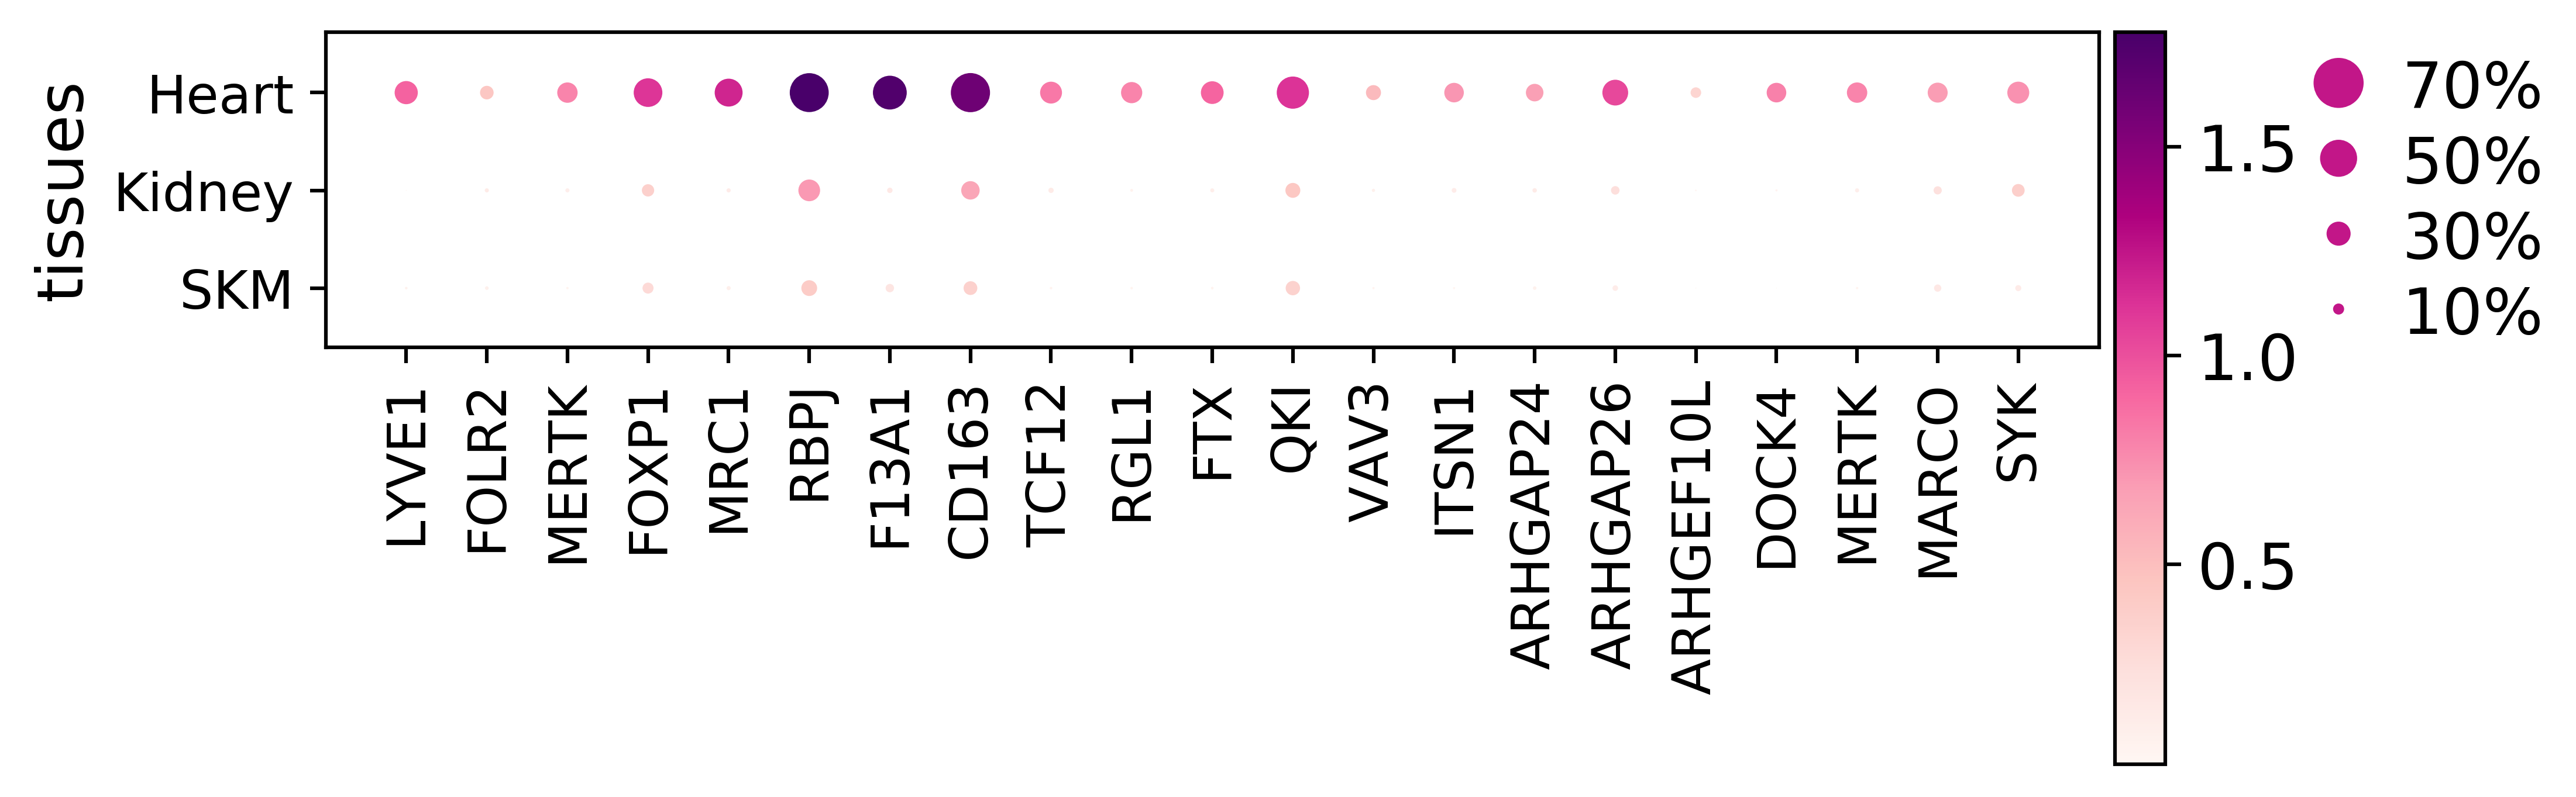

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.05, 0, 0.2, 0.5, 0.25])

In [84]:
#sc.tl.dendrogram(HKM_myeloid, groupby = 'tissues')
sc.pl.dotplot(HKM_myeloid, cardiac_myeloid, groupby = 'tissues', color_map = 'RdPu', dendrogram = False, figsize = (8,3))

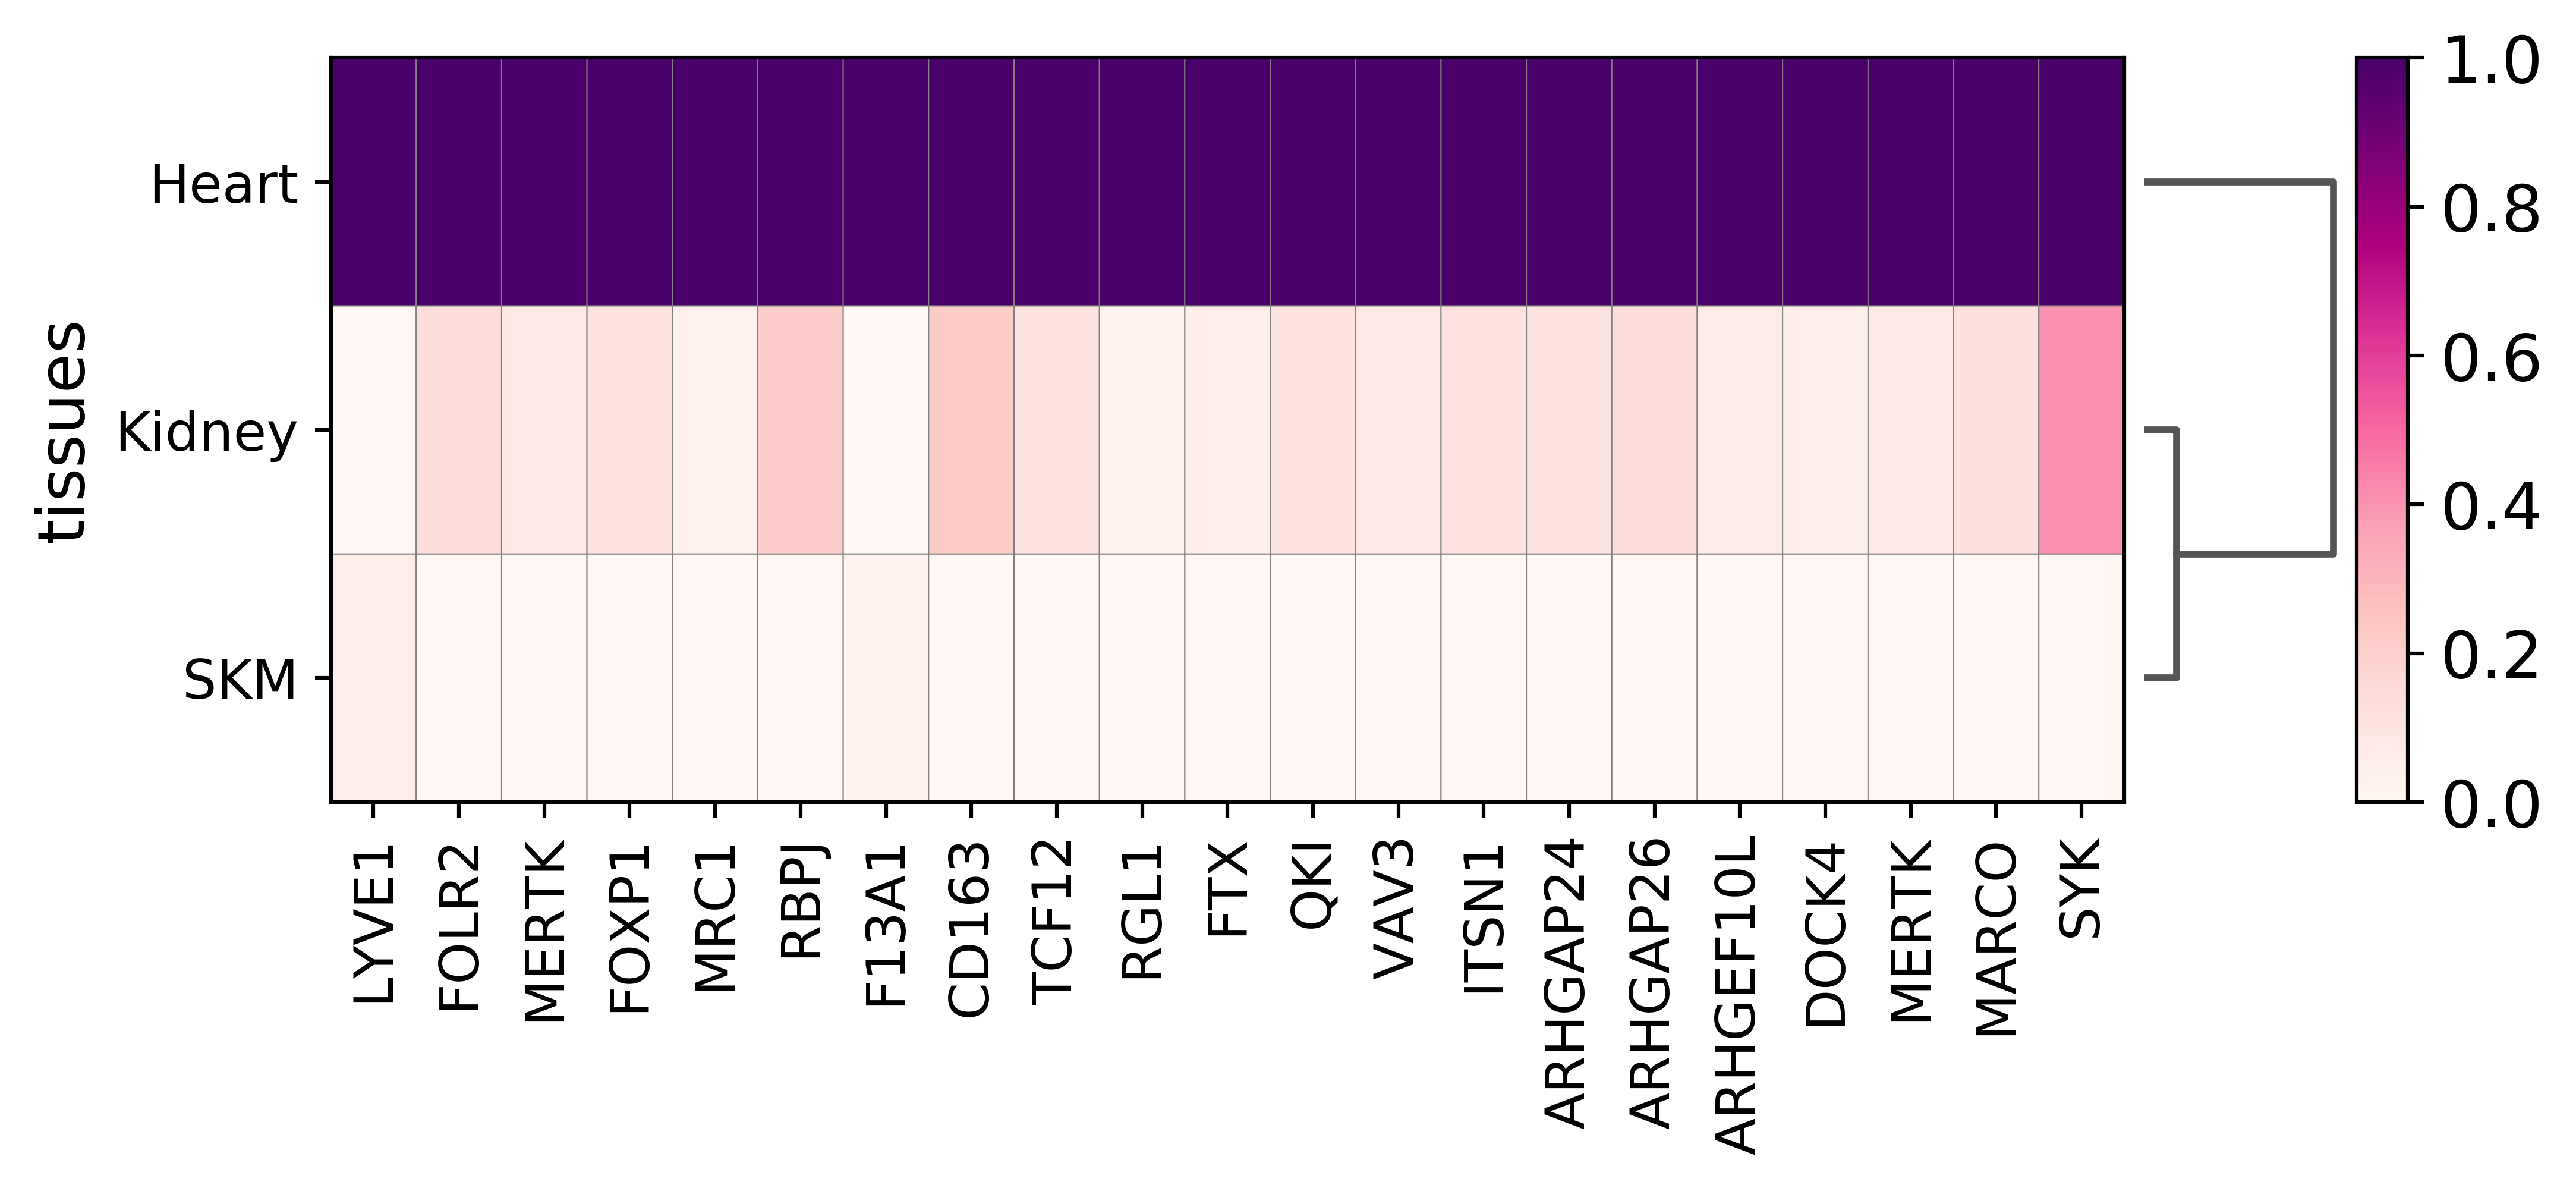

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[7.0, 0.8, 0.2])

In [85]:
sc.pl.matrixplot(HKM_myeloid, cardiac_myeloid, groupby = 'tissues', cmap = 'RdPu', dendrogram = True, figsize = (8,3), standard_scale = 'var')

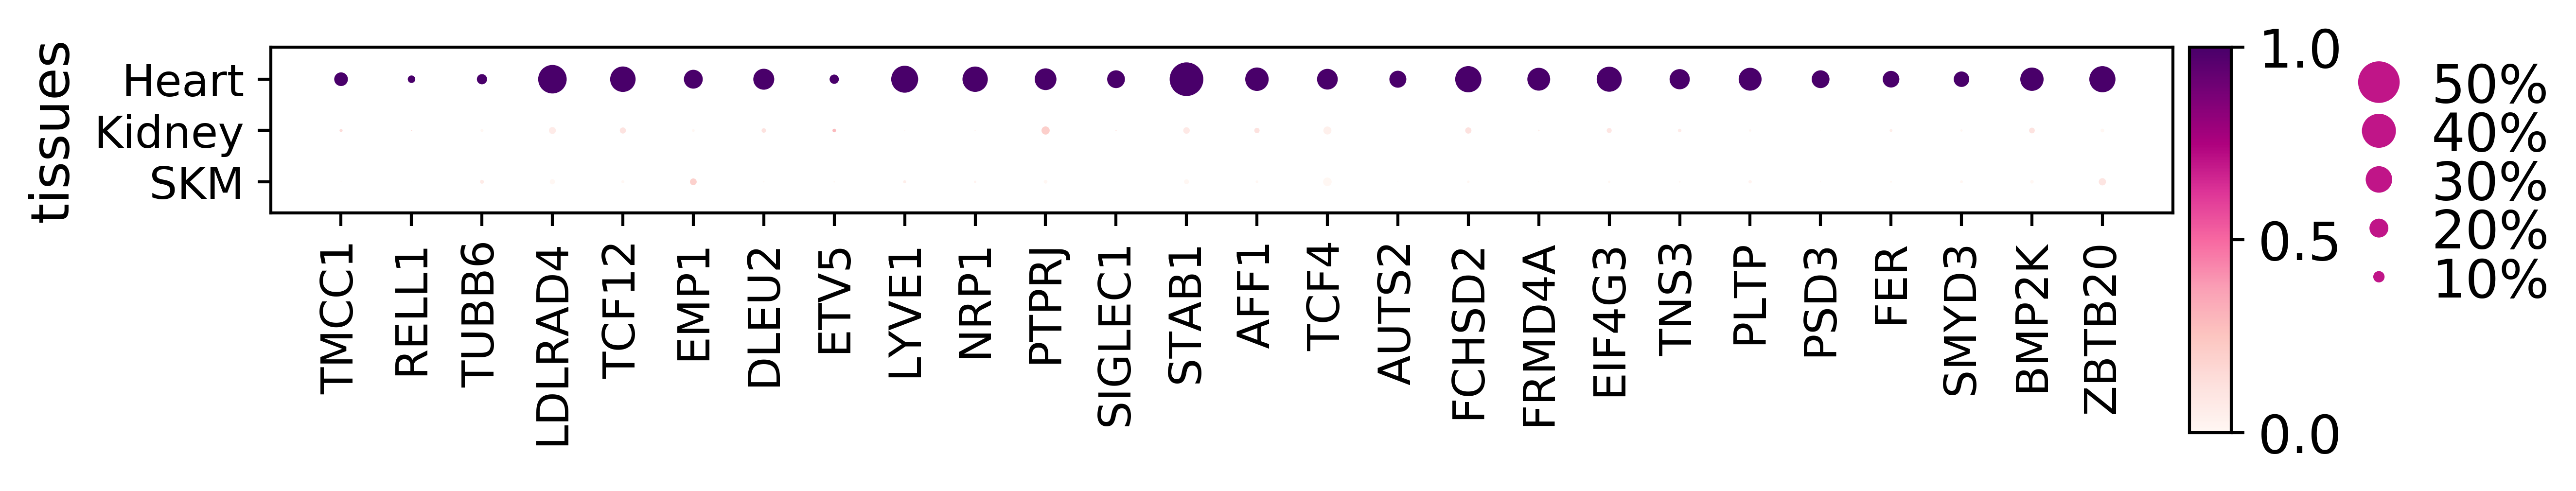

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[9.1, 0, 0.2, 0.5, 0.25])

In [103]:
PYSCENIC=['TMCC1','RELL1','TUBB6','LDLRAD4','TCF12','EMP1','DLEU2','ETV5','LYVE1','NRP1','PTPRJ','SIGLEC1','STAB1','AFF1','TCF4','AUTS2','FCHSD2','FRMD4A','EIF4G3','TNS3','PLTP','PSD3','FER','SMYD3','BMP2K','ZBTB20']
sc.pl.dotplot(HKM_myeloid, PYSCENIC, groupby = 'tissues', color_map = 'RdPu', dendrogram = False, save = "_dotplot_HKM_myeloid_ctl200606.svg" , standard_scale = 'var')

In [ ]:
PYSCENIC=['LYVE1','STAB1','FOLR2','CPEB4','ABCA1','ABR','EMP1','SIGLEC1','PTPRJ','SIPA1L1','ZSWIM6','ARHGAP26','TCF4','NAV2','LINGO1','ELF2','RBMS1','AFF1','RBM47','HDAC9','ACTC1','VSIG4','NRP1']
sc.pl.matrixplot(HKM_myeloid, PYSCENIC, groupby = 'tissues', cmap = 'RdPu', dendrogram = True, figsize = (8,2), standard_scale = 'var' )

In [ ]:
PYSCENIC = ['ETV5','LYVE1','NRP1','PTPRJ','SIGLEC1','STAB1','AFF1','ARHGAP26','ELF2','RBM47','SIPA1L1','TCF4']
#PYSCENIC=['CPEB4','ABCA1','ABR','EMP1','LYVE1','SIGLEC1','PTPRJ','SIPA1L1','STAB1','ZSWIM6','ARHGAP26','TCF4','NAV2','LINGO1','ELF2','RBMS1','AFF1','RBM47','FOLR2','HDAC9','ACTC1','VSIG4','NRP1','ETV5']
sc.pl.dotplot(HKM_myeloid, PYSCENIC, groupby = 'tissues', color_map = 'RdPu', dendrogram = False, figsize = (8,4), standard_scale = 'var', save = '_HKM_myeloid_ctl200606.svg')

In [ ]:
sc.pl.stacked_violin(HKM_myeloid, PYSCENIC, groupby = 'tissues', dendrogram = True, standard_scale = 'var', figsize = (8,2))